In [30]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
# NetworkX for graph handling
import networkx as nx

# Torch and PyTorch Geometric for graph-based learning
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import from_networkx, add_self_loops, degree, remove_self_loops

# SciPy for handling matrix files
from scipy.io import mmread
import seaborn as sns

In [31]:
N=500
m=3
G = nx.barabasi_albert_graph(N, m)

In [32]:
n_nodes = len(G.nodes)
n_nodes

500

Text(0.5, 1.0, 'Network Degree Distribution')

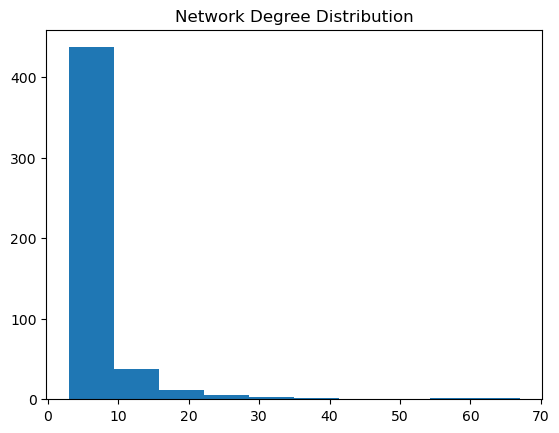

In [33]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
fig, ax = plt.subplots()
ax.hist(degree_sequence)
ax.set_title("Network Degree Distribution")

In [34]:
# this also may take a while
edge_index = from_networkx(G).edge_index

In [35]:
edge_index.shape

torch.Size([2, 2982])

## Model Params
* alpha = matrix of population openness values
* 
confidence_bound = matrix of population confidence bound
* 
r = network growth ra
* e
N_max = network carrying capac
* ty
gamma = churn scaling fa
* tor
lambda_m = average rate of new connections for new arrivals

In [36]:
class BeliefMessagePassing(MessagePassing):
    """
    Implements a message-passing mechanism for belief propagation in a network.

    This model simulates how beliefs spread over a network based on neighbors' 
    beliefs and an individual's openness to external influence.

    Attributes:
        linear (torch.nn.Linear): A linear transformation applied to aggregated messages.
        num_timesteps (int): Number of propagation steps in the message-passing process.
    """

    def __init__(self, in_channels=1, out_channels=1, num_timesteps: int = 5):
        """
        Initializes the belief propagation model.

        Args:
            in_channels (int): Dimensionality of input node features. Defaults to 1.
            out_channels (int): Dimensionality of transformed node features. Defaults to 1.
            num_timesteps (int, optional): Number of message-passing iterations. Defaults to 5.
        """
        super().__init__(aggr='mean')  # Use mean aggregation of messages
        self.linear = torch.nn.Linear(in_channels, out_channels)
        self.num_timesteps = num_timesteps

    def forward(self, x, edge_index, alpha_matrix=None, confidence_bound=None, r=0.2, N_max=50000,
               gamma=0.1, lambda_m=2, verbose=False):
        """
        Forward pass for belief propagation.

        Args:
            x (torch.Tensor): Node feature matrix of shape (num_nodes, in_channels).
            edge_index (torch.Tensor): Graph connectivity in COO format.
            alpha_matrix (torch.Tensor, optional): Openness values for each node. Shape: (num_nodes, 1).

        Returns:
            torch.Tensor: Updated node features after belief propagation.
            list[torch.Tensor]: List of node embeddings over time.
        """
        # Initialize alpha_matrix (openness) if not provided
        if alpha_matrix is None:
            alpha_matrix = torch.rand((x.size(0), 1))  # Random openness values
        if confidence_bound is None:
            confidence_bound = torch.rand((x.size(0), 1)) * 0.5 # Confidence bound between 0 and 0.5

        # Store belief embeddings at each timestep
        embeddings_over_time = [x.clone().detach()]
        edge_indices_over_time = [edge_index.clone()]

        # Message passing for multiple timesteps
        for _ in tqdm(range(self.num_timesteps), desc="Belief Propagation Steps"):
            if verbose:
                connections = edge_index.shape[1]
                pop_size = x.shape[0]
                print(f"Timestep {_}: Network Size: {pop_size} | Connections {connections}")
            
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            
            row, col = edge_index
            deg = degree(row, num_nodes=x.size(0), dtype=x.dtype)
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # Handle isolated nodes
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]  # Update normalization
            
            x = self.propagate(edge_index, x=x, norm=norm, alpha_matrix=alpha_matrix,
                              confidence_bound=confidence_bound)
            edge_index = self.update_edges(edge_index, x, confidence_bound)
            edge_index, x, alpha_matrix, confidence_bound = self.node_churn(edge_index, x, 
                                                                            alpha_matrix, 
                                                                            confidence_bound,
                                                                            gamma)
            edge_index, x, alpha_matrix, confidence_bound = self.add_nodes(edge_index, x,
                                                                           alpha_matrix,
                                                                           confidence_bound,
                                                                           r, N_max, lambda_m)

            embeddings_over_time.append(x.clone().detach())
            edge_indices_over_time.append(remove_self_loops(edge_index.clone())[0])
            
        return x, embeddings_over_time, edge_indices_over_time

    def message(self, x_j, norm):
        """
        Message function that applies degree normalization to incoming messages.

        Args:
            x_j (torch.Tensor): Features of neighboring nodes.
            norm (torch.Tensor): Degree normalization factor.

        Returns:
            torch.Tensor: Normalized messages.
        """
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out, x, alpha_matrix, confidence_bound):
        """
        Update function that determines how beliefs change based on neighbors' beliefs.

        Args:
            aggr_out (torch.Tensor): Aggregated messages from neighbors.
            x (torch.Tensor): Current node beliefs.
            alpha_matrix (torch.Tensor): Openness values for each node.

        Returns:
            torch.Tensor: Updated belief values.
        """
        # Compute similarity between a node's current belief and the aggregated belief from neighbors
        similarity = torch.cosine_similarity(aggr_out, x, dim=-1, eps=1e-6).unsqueeze(-1)

        # Compute updated belief: a node is influenced by neighbors' beliefs based on similarity
        updated_belief = similarity * self.linear(aggr_out) + (1 - similarity) * x

        # Soft thresholding using a sigmoid function to gradually reduce influence
        influence_weight = torch.sigmoid((similarity - confidence_bound.view(-1, 1)) * 10)

        # Final belief update incorporating openness (alpha_matrix)
        final_belief = torch.tanh(alpha_matrix * updated_belief + (1 - alpha_matrix) * x)
        # return torch.tanh(alpha_matrix * updated_belief + (1 - alpha_matrix) * x)

        result = influence_weight * final_belief + (1 - influence_weight) * x
        
        return result

    def logistic_growth(self, num_nodes, r, N_max):
        lambda_t = r * num_nodes * (1 - (num_nodes / N_max))
        return np.random.poisson(lambda_t)

    def barabasi_albert_attachment(self, edge_index, num_nodes, new_nodes, lambda_m):
        degrees = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.float) + 1e-6
        probs = degrees / degrees.sum()

        new_edges = []
        for new_node in range(num_nodes, num_nodes + new_nodes):
            m = max(1, np.random.poisson(lambda_m))
            neighbors = np.random.choice(num_nodes, size=min(m, num_nodes), replace=False, p=probs.numpy())

            for neighbor in neighbors:
                new_edges.append([new_node, neighbor])
                new_edges.append([neighbor, new_node])

        if new_edges:
            new_edges = torch.tensor(new_edges, dtype=torch.long).T
            edge_index = torch.cat([edge_index, new_edges], dim=1)

        return edge_index

    def add_nodes(self, edge_index, x, alpha_matrix, confidence_bound, r, N_max, lambda_m):
        num_nodes = x.size(0)

        new_nodes = self.logistic_growth(num_nodes, r, N_max)
        if new_nodes == 0:
            return edge_index, x, alpha_matrix, confidence_bound

        new_x = torch.rand((new_nodes, x.size(1))) * 2 - 1  
        new_confidence_bound = torch.rand((new_nodes, 1)) * 0.5
        new_alpha_matrix = torch.rand((new_nodes, 1))

        x = torch.cat([x, new_x], dim=0)
        confidence_bound = torch.cat([confidence_bound, new_confidence_bound], dim=0)
        alpha_matrix = torch.cat([alpha_matrix, new_alpha_matrix], dim=0)

        edge_index = self.barabasi_albert_attachment(edge_index, num_nodes, new_nodes, lambda_m)

        return edge_index, x, alpha_matrix, confidence_bound

    def node_churn(self, edge_index, x, alpha_matrix, confidence_bound, gamma):
        num_nodes = x.size(0)
        degrees = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.float)

        p_leave = gamma * (1 - degrees / (degrees.max() + 1e-6))
        remove_mask = torch.bernoulli(1 - p_leave).bool()

        x = x[remove_mask]
        alpha_matrix = alpha_matrix[remove_mask]
        confidence_bound = confidence_bound[remove_mask]

        mask_idx = torch.arange(num_nodes)[remove_mask]
        node_map = -torch.ones(num_nodes, dtype=torch.long)
        node_map[mask_idx] = torch.arange(len(mask_idx))

        row, col = edge_index
        valid_edges = remove_mask[row] & remove_mask[col]
        edge_index = edge_index[:, valid_edges]
        edge_index = node_map[edge_index]

        return edge_index, x, alpha_matrix, confidence_bound
        
    def update_edges(self, edge_index, x, confidence_bound):
        row, col = edge_index
        belief_difference = torch.abs(x[row] - x[col])
        
        # Remove edges
        keep_edges = belief_difference < confidence_bound[row]
        edge_index = edge_index[:, keep_edges.squeeze()]

        num_nodes = x.size(0)

        # Randomly select a subset of nodes to attempt new connections
        num_active_nodes = torch.randint(1, num_nodes // 5 + 1, (1,)).item()
        active_nodes = torch.randperm(num_nodes)[:num_active_nodes]

        new_edges = []
        
        for node in active_nodes:
            belief_diff = torch.abs(x - x[node])
            valid_candidates = (belief_diff < confidence_bound[node]).nonzero(as_tuple=True)[0]

            if valid_candidates.numel() == 0:
                continue

            max_attempts = torch.randint(1, max(2, num_nodes // 10) + 1, (1,)).item()
            num_new_edges = torch.randint(1, min(max_attempts, valid_candidates.numel()) + 1, (1,)).item()
            chosen = valid_candidates[torch.randperm(valid_candidates.numel())[:num_new_edges]]

            for target in chosen:
                p_connect = 1 - (belief_diff[target] / confidence_bound[node]).item()  # Higher belief similarity → higher chance
                if torch.rand(1).item() < p_connect:  # Stochastic connection
                    new_edges.append([node, target.item()])
        
        if not new_edges:
            return edge_index
            
        new_edges = torch.tensor(new_edges).T
        
        return torch.cat([edge_index, new_edges], dim=1)

In [37]:
edge_index.shape[1]

2982

**Note:** I was too lazy to code the population generator so I just GPTed this. Some of the distributions missing are uniform distribution for beliefs and bimodal distributions for openness.

In [38]:
class PopulationGenerator:
    def __init__(self, G: nx.Graph, 
                 belief_dist="normal", openness_dist="uniform", confidence_bound_dist="uniform",
                 belief_params=None, openness_params=None, confidence_bound_params=None):
        """
        Initialize the population generator.

        Parameters:
        - G (nx.Graph): The network graph.
        - belief_dist (str): Type of belief distribution ("normal", "bimodal", "beta").
        - openness_dist (str): Type of openness distribution ("uniform", "normal", "beta").
        - belief_params (dict): Parameters for belief distribution.
        - openness_params (dict): Parameters for openness distribution.
        """
        self.G = G
        self.belief_dist = belief_dist
        self.openness_dist = openness_dist
        self.confidence_bound_dist = confidence_bound_dist
        
        self.belief_params = belief_params if belief_params else {}
        self.openness_params = openness_params if openness_params else {}
        self.confidence_bound_params = confidence_bound_params if confidence_bound_params else {}

    def generate_beliefs(self, num_nodes):
        """Generates belief values based on the selected distribution."""
        if self.belief_dist == "normal":
            mean = self.belief_params.get("mean", 0)
            std = self.belief_params.get("std", 0.5)
            beliefs = np.random.normal(loc=mean, scale=std, size=num_nodes)

        elif self.belief_dist == "bimodal":
            size1 = num_nodes // 2
            size2 = num_nodes - size1
            beliefs = np.concatenate([
                np.random.normal(loc=-0.8, scale=0.2, size=size1),
                np.random.normal(loc=0.8, scale=0.2, size=size2)
            ])

        elif self.belief_dist == "beta":
            a = self.belief_params.get("a", 5)
            b = self.belief_params.get("b", 2)
            beliefs = 2 * np.random.beta(a, b, size=num_nodes) - 1  # Scale to [-1,1]

        else:
            raise ValueError("Unsupported belief distribution type!")

        return np.clip(beliefs, -1, 1)  # Clip between -1 and 1

    def generate_openness(self, num_nodes):
        """Generates openness values based on the selected distribution."""
        if self.openness_dist == "uniform":
            a = self.openness_params.get("a", 0.1)
            b = self.openness_params.get("b", 0.9)
            openness = np.random.uniform(a, b, size=num_nodes)

        elif self.openness_dist == "normal":
            mean = self.openness_params.get("mean", 0.5)
            std = self.openness_params.get("std", 0.1)
            openness = np.random.normal(loc=mean, scale=std, size=num_nodes)

        elif self.openness_dist == "beta":
            a = self.openness_params.get("a", 2)
            b = self.openness_params.get("b", 5)
            openness = np.random.beta(a, b, size=num_nodes)  # Beta is naturally [0,1]

        else:
            raise ValueError("Unsupported openness distribution type!")

        return np.clip(openness, 0, 1)  # Openness should always be in [0,1]
        
    def generate_confidence_bound(self, num_nodes):
        """Generates confidence bound values based on the selected distribution."""
        if self.confidence_bound_dist == "uniform":
            a = self.confidence_bound_params.get("a", 0.1)
            b = self.confidence_bound_params.get("b", 0.5)
            confidence_bound = np.random.uniform(a, b, size=num_nodes)

        elif self.confidence_bound_dist == "normal":
            mean = self.confidence_bound_params.get("mean", 0.3)
            std = self.confidence_bound_params.get("std", 0.1)
            confidence_bound = np.random.normal(loc=mean, scale=std, size=num_nodes)

        elif self.confidence_bound_dist == "beta":
            a = self.confidence_bound_params.get("a", 2)
            b = self.confidence_bound_params.get("b", 5)
            confidence_bound = np.random.beta(a, b, size=num_nodes) * 0.5  # Scale to [0, 0.5]

        else:
            raise ValueError("Unsupported confidence bound distribution type!")

        return np.clip(confidence_bound, 0, 0.5)  # Confidence bound should be between 0 and 0.5

    def generate(self):
        """Generates the population and returns belief and openness tensors."""
        num_nodes = len(self.G.nodes)

        # Generate beliefs and openness
        beliefs = self.generate_beliefs(num_nodes)
        openness = self.generate_openness(num_nodes)
        confidence_bound = self.generate_confidence_bound(num_nodes)

        # Convert to PyTorch tensors
        x = torch.from_numpy(beliefs).float().view(-1, 1)  # Belief tensor
        alpha_matrix = torch.from_numpy(openness).float().view(-1, 1)  # Openness tensor
        confidence_bound_tensor = torch.from_numpy(confidence_bound).float().view(-1, 1)  # Confidence tensor

        return x, alpha_matrix, confidence_bound_tensor

# Belief and Openness Distributions

**Note: I was also too lazy to explain the distributions so I had GPT do this too. Some of the distribution options it lists here might not be available in the population generator class.**

When modeling belief and openness in a network, different probability distributions can be used to reflect various societal or structural influences on how beliefs form and spread. Below are several distribution types and their appropriate use cases.

## 1. **Normal Distribution**
   - **Description**: A unimodal, symmetric distribution where most values cluster around the mean, with fewer extreme values.
   - **When to Use**: 
     - When belief formation is influenced by multiple small, independent factors.
     - In environments where beliefs follow a natural tendency toward moderate positions, with fewer extreme believers or disbelievers.
     - When openness levels are normally distributed due to social and cognitive diversity.

## 2. **Bimodal Distribution**
   - **Description**: A distribution with two peaks, representing two dominant groups of belief (e.g., strong believers and strong disbelievers).
   - **When to Use**: 
     - When the population is polarized, possibly due to confirmation bias, echo chambers, or media influence.
     - In scenarios where social or algorithmic reinforcement leads to a lack of moderate perspectives.
     - If openness is similarly polarized, where one group is highly open and another is very closed.

## 3. **Beta Distribution (Skewed)**
   - **Description**: A flexible distribution that can be skewed toward one extreme (e.g., most people leaning toward belief or disbelief).
   - **When to Use**:
     - When belief formation is dominated by strong external influences like political, religious, or cultural indoctrination.
     - In cases where the majority leans toward one view, but a minority still holds an opposing belief.
     - When openness is shaped by a dominant cultural norm, where most people are either highly open or highly closed.

## 4. **Uniform Distribution**
   - **Description**: A flat distribution where all values are equally likely.
   - **When to Use**: 
     - When beliefs are initialized randomly without any inherent bias.
     - In experimental setups where no prior assumption is made about how belief is distributed.
     - When modeling openness in an unpredictable or chaotic environment.

Each of these distributions provides a different lens for modeling how belief and openness are structured in a population. The choice of distribution should be guided by empirical data or theoretical considerations based on the environment being simulated.


In [42]:
# default population belief distribution is normal and openness distribution is uniform, we can change this tbh so that both are normal or to adapt openness based on other studies we can find
# the generator is also already monte-carlo-ed since it randomly generates a new kind of population each time
pop_gen = PopulationGenerator(G)
x, alpha_matrix, confidence_bound = pop_gen.generate()

In [43]:
model = BeliefMessagePassing(in_channels=1, out_channels=1, num_timesteps=20)
final, over_time, edge_over_time = model(x, edge_index, alpha_matrix, confidence_bound, verbose=True)

Belief Propagation Steps:  15%|█▌        | 3/20 [00:00<00:00, 23.26it/s]

Timestep 0: Network Size: 500 | Connections 2982
Timestep 1: Network Size: 548 | Connections 2217
Timestep 2: Network Size: 599 | Connections 3444
Timestep 3: Network Size: 653 | Connections 4454
Timestep 4: Network Size: 697 | Connections 5150


Belief Propagation Steps:  30%|███       | 6/20 [00:00<00:00, 24.25it/s]

Timestep 5: Network Size: 759 | Connections 6133
Timestep 6: Network Size: 849 | Connections 6715
Timestep 7: Network Size: 946 | Connections 8882


Belief Propagation Steps:  45%|████▌     | 9/20 [00:00<00:00, 13.32it/s]

Timestep 8: Network Size: 1028 | Connections 10204
Timestep 9: Network Size: 1142 | Connections 13291
Timestep 10: Network Size: 1258 | Connections 16128


Belief Propagation Steps:  55%|█████▌    | 11/20 [00:01<00:01,  7.15it/s]

Timestep 11: Network Size: 1387 | Connections 20603


Belief Propagation Steps:  65%|██████▌   | 13/20 [00:01<00:00,  7.34it/s]

Timestep 12: Network Size: 1548 | Connections 23004
Timestep 13: Network Size: 1703 | Connections 22406
Timestep 14: Network Size: 1872 | Connections 29699


Belief Propagation Steps:  80%|████████  | 16/20 [00:02<00:00,  4.38it/s]

Timestep 15: Network Size: 2019 | Connections 38406
Timestep 16: Network Size: 2205 | Connections 37214


Belief Propagation Steps:  85%|████████▌ | 17/20 [00:02<00:00,  4.05it/s]

Timestep 17: Network Size: 2389 | Connections 40640


Belief Propagation Steps:  90%|█████████ | 18/20 [00:03<00:00,  3.13it/s]

Timestep 18: Network Size: 2634 | Connections 49668


Belief Propagation Steps:  95%|█████████▌| 19/20 [00:03<00:00,  2.96it/s]

Timestep 19: Network Size: 2891 | Connections 54731


Belief Propagation Steps: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Run the cell below to graph out the believers at each time step

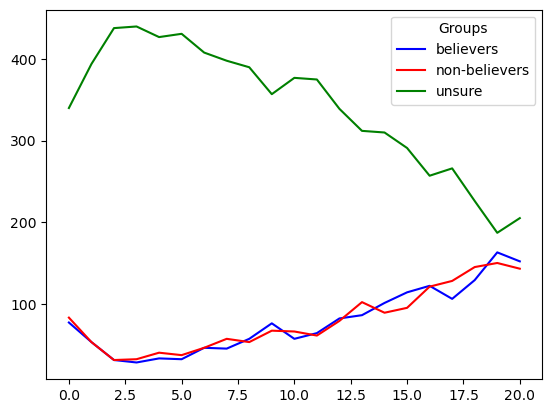

In [44]:
believers_over_time = []
nonbelievers_over_time = []
moderates_over_time = []

for timestep in over_time:
    believers = (timestep > 0.5).sum(dim=0)
    believers_over_time.append(believers)

    nonbelievers = (timestep <-0.5).sum(dim=0)
    nonbelievers_over_time.append(nonbelievers)

    total_pop = len(G.nodes)
    moderates_over_time.append(total_pop - (nonbelievers + believers))

fig, ax = plt.subplots()
ax.plot(range(0,model.num_timesteps+1), believers_over_time, color='blue', label='believers')
ax.plot(range(0,model.num_timesteps+1), nonbelievers_over_time, color='red', label='non-believers')
ax.plot(range(0,model.num_timesteps+1), moderates_over_time, color='green', label='unsure')
ax.legend(title='Groups', loc='upper right')

In [ ]:
%matplotlib notebook

from IPython.display import HTML
import IPython

def animate_model(embeddings_over_time, edge_indices_over_time):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Collect all unique nodes across all timesteps
    all_nodes = set()
    for edge_index in edge_indices_over_time:
        all_nodes.update(edge_index.cpu().numpy().flatten())

    # Ensure node indices are sequential (avoid gaps)
    sorted_nodes = sorted(all_nodes)
    node_to_index = {node: i for i, node in enumerate(sorted_nodes)}

    # Create a fixed layout
    G_static = nx.Graph()
    G_static.add_nodes_from(sorted_nodes)
    pos = nx.spring_layout(G_static, seed=42)

    def update(frame):
        ax.clear()
        timestep = embeddings_over_time[frame].cpu().numpy()  # Ensure correct tensor handling
        edge_index = edge_indices_over_time[frame].cpu().numpy()
    
        G.clear()
        G.add_edges_from(edge_index.T)
    
        # Ensure node indexing is updated dynamically
        node_to_index = {node: i for i, node in enumerate(G.nodes())}
    
        node_colors = []
        for node in G.nodes():
            if node in node_to_index and node_to_index[node] < len(timestep):  # Bounds check
                val = timestep[node_to_index[node]]
                if val > 0.5:
                    node_colors.append('green')
                elif val < -0.5:
                    node_colors.append('red')
                else:
                    node_colors.append('gray')
            else:
                node_colors.append('gray')  # Default color for unmapped nodes
    
        nx.draw(G, pos, node_color=node_colors, ax=ax, with_labels=False, node_size=50)
        ax.set_title(f'Timestep {frame + 1}/{len(embeddings_over_time)}')

    ani = animation.FuncAnimation(fig, update, frames=len(embeddings_over_time), interval=500, repeat=True)
    ani.save('graph_animation.gif', writer='pillow', fps=10)
    display(HTML(ani.to_jshtml()))

In [368]:
animate_model(over_time, edge_over_time)

<IPython.core.display.Javascript object>

# TODO:
* Implement different scenarios in the PopulationGenerator class like:
  * echo-chambers where people with similar beliefs tend to be more connected and a node's belief is closer to the average of its neighbors; or
  * polarized groups where there is a strong division between two opposing groups
* Document and explain all this code and math lol 